In [1]:
import sys


path = "/home/someone/stage_jonathan/lightning-sam/lightning-sam/l_sam_env/lib/python3.10/site-packages"

if path not in sys.path:
    sys.path.append(path)

In [2]:
from config import cfg

In [3]:
path_to_img = "/mnt/data/CUB_200_2011/images"

In [4]:
import os 
import cv2
import matplotlib.pyplot as plt

In [5]:
file = os.listdir(path_to_img)[150]
print(file)

148.Green_tailed_Towhee


In [6]:
 file+"/"+os.listdir(os.path.join(path_to_img,file))[5]

'148.Green_tailed_Towhee/Green_Tailed_Towhee_0018_154825.jpg'

In [7]:
img = cv2.imread(os.path.join(path_to_img+"/"+file, 
                              os.listdir(os.path.join(path_to_img,
                                                      file))[5]))

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

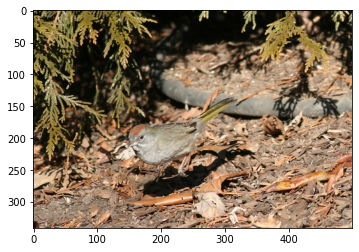

In [8]:
plt.imshow(img)
plt.show()

In [9]:

box_file = "/mnt/data/CUB_200_2011/bounding_boxes.txt"
img_dir = "/mnt/data/CUB_200_2011/images.txt"


with open(box_file,"r") as f:
    temp = f.readlines()

    # format i x1 y1 x2 y2 
    boxes = [list(map(lambda x : int(float(x)), line.split()[1:])) for line in temp] 

with open(img_dir,"r") as f:
    temp = f.readlines()
    # format i folder_name/image_name
    img_names = [os.path.join(path_to_img,line.split()[1]) for line in temp]

In [10]:
from custom_transform import LocalizedRandomResizedCrop

In [11]:
idx = [(i,name) for (i,name) in enumerate(img_names) if  file+"/"+os.listdir(os.path.join(path_to_img,file))[5] in name ][0]

In [12]:
boxes[idx[0]]

[144, 127, 177, 142]

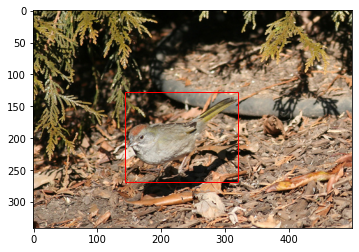

In [13]:
# convert to PIL
from PIL import Image
from matplotlib.patches import Rectangle

img_pil = Image.fromarray(img)

# (x,y) , w, h
fig, ax = plt.subplots()
ax.imshow(img_pil)
x,y,xw,yh = boxes[idx[0]]


rect = Rectangle((x,y),xw,yh, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

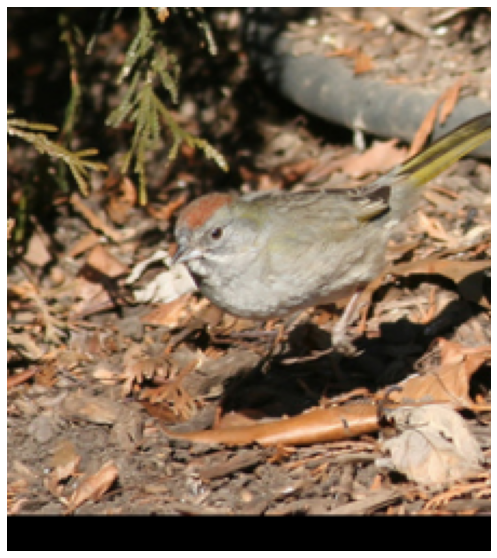

In [14]:
x,y,w,h = boxes[idx[0]]

cropped = LocalizedRandomResizedCrop(img_pil,[x,y,w,h],size=224, alpha=0.5)
plt.figure(figsize=(10,10))
plt.imshow(cropped)
plt.axis("off")
plt.show()

In [15]:
!nvidia-smi

Tue Aug  1 11:30:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN X (Pascal)         On | 00000000:03:00.0 Off |                  N/A |
| 23%   33C    P8               20W / 250W|    658MiB / 12288MiB |     50%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
from tqdm.notebook import tqdm
import torch
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

Using cache found in /home/someone/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [17]:
for name, param in dinov2_vits14.named_children():
    print(name)

patch_embed
blocks
norm
head


In [18]:
dinov2_vits14.to("cuda")

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedT

In [19]:
import numpy as np
(torch.Tensor(np.array(cropped))).shape

torch.Size([252, 224, 3])

In [20]:
%%time

inputs = torch.Tensor(np.array(cropped)).permute(2,0,1).unsqueeze(0)
inputs = inputs.to("cuda")
with torch.inference_mode():
    out = dinov2_vits14(torch.Tensor(inputs))
    
print(out.shape)

torch.Size([1, 384])
CPU times: user 594 ms, sys: 282 ms, total: 876 ms
Wall time: 795 ms
